**Methods**

Decision trees are a great way to classify between two labels (can also be done with more than two). From a general point of view, the tree asks questions and splits data based on the answers. It will continue to ask questions until it perfectly splits the data into their respective labels, so we have to make sure not to overfit. An example: if we were to classify house prices, the first question might be “is the house in an expensive neighborhood?”. This would lead to a split of the data and then the process would continue.

The decision tree is meant to boil things down as much as possible, to a point where all the data is split into their respective category. The problem with this method is that if allowed, it will overfit to the training data and perform poorly on the test data. To fix this, we can specify hyperparameters within the model such as maximum depth (i.e., how many questions the tree can ask), required data instances to ask another question (i.e., how many data instances have to fall under a leaf to ask another question), and a few others.

In the end, the best result will be one that maximizes the accuracy of both training and test data. If we are maximizing both, it means that the generalization the model is making works both in theory and practice. A next step for this model would be to use a random forest, rather than a decision tree, which creates many decision trees and creates a “vote” of the results to assign a label to your predicted data.

**Class distribution**
We don't need to dive deep into the data to figure this out. In each World Cup, half of the teams advance and half of the teams get eliminated in the group stage, so there is a perfect balance between labels of making it out of the group stage and not. A perfect means that the tree, or any other model, will weight either label more heavily.

**Using a decision tree for my project predictions**

The first step is to import the libraries required to work with the data and create the model.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

/Users/modeedna/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Feature selection and working with the data**

After importing the required libraries, I brought in the required dataframe and thought about which features to select. I used the same features utilized for the Naive Bayes predictions. The method used there was to remove variable that had high correlation amongst themselves and I also removed variables that had no correlation whatsoever with the prediction labels.
In the same cell, I also normalized the data and separated it into training and testing sets to train the model and later qualify its ability to predict the labels.

In [2]:
# import dataframe
df = pd.read_csv('../../data/cleanData/allTables.csv')
# select wanted columns, removed caps
df2 = df[['eliteClub','RankFIFA','DifficultGroup', 'Host', 'QualiStreak', 'Age']]
label = df[['PastGroup']]
# normalize data
scaler = MinMaxScaler()
dfscaled = scaler.fit_transform(df2)
# separate data
X_train, X_test, y_train, y_test = train_test_split(dfscaled, label, test_size=0.25, random_state=42)

**Default tree**

I decided to make an initial attempt with default values for the decision tree to see what the outcome would be. I then created a function that would return the confusion matrix and some metrics (e.g. Accuracy, recall, etc.) to evaluate the tree's performance. After this, I printed the tree to see a visual representation of how the decisions were being made.


In [3]:
# function to generate a confusion matrix and metrics
def confusion_plot(y_data,y_pred):
    from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay
    cm = confusion_matrix(y_data, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    print('ACCURACY: ' + str((tn+tp)/(tn+fp+fn+tp)))
    print('NEGATIVE RECALL (Y=0): ' + str(tn/(tn+fp)))
    print('NEGATIVE PRECISION (Y=0): ' + str(tn/(tn+fn)))
    print('POSITIVE RECALL (Y=1): ' + str(tp/(tp+fn)))
    print('POSITIVE PRECISION (Y=1): ' + str(tp/(tp+fp)))
    print(np.array([[tn, fp], [fn, tp]]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [4]:
# create and train the model first attempt
clf = tree.DecisionTreeClassifier(random_state=42)
model = clf.fit(X_train,y_train)
# making predictions with the model on the training and the testing data
yp_train = model.predict(X_train)
yp_test = model.predict(X_test)

------TRAINING------
ACCURACY: 1.0
NEGATIVE RECALL (Y=0): 1.0
NEGATIVE PRECISION (Y=0): 1.0
POSITIVE RECALL (Y=1): 1.0
POSITIVE PRECISION (Y=1): 1.0
[[61  0]
 [ 0 59]]


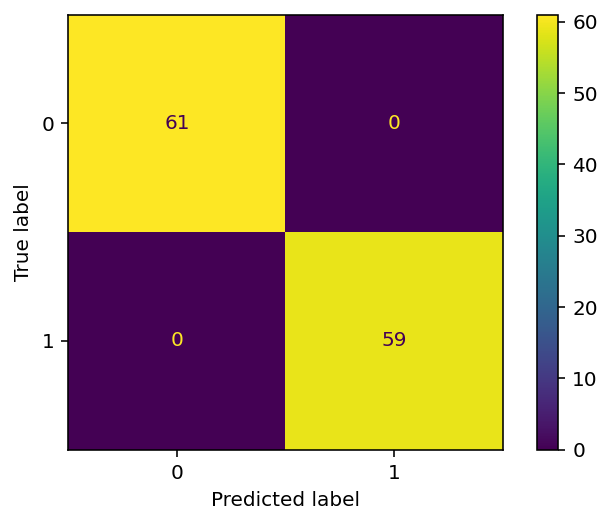

------TEST------
ACCURACY: 0.6
NEGATIVE RECALL (Y=0): 0.5789473684210527
NEGATIVE PRECISION (Y=0): 0.5789473684210527
POSITIVE RECALL (Y=1): 0.6190476190476191
POSITIVE PRECISION (Y=1): 0.6190476190476191
[[11  8]
 [ 8 13]]


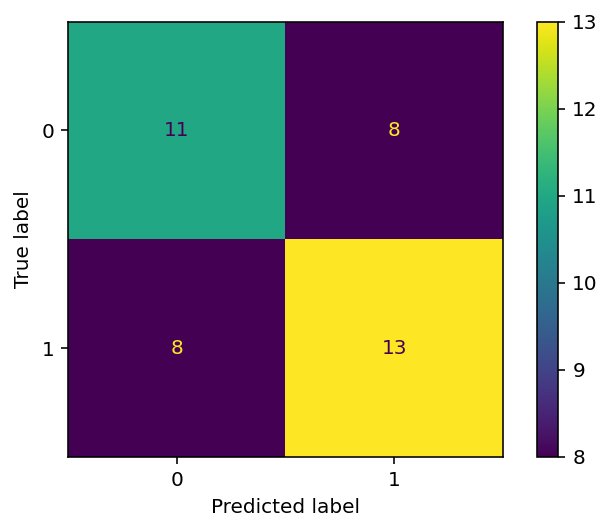

In [5]:
# use the function
print("------TRAINING------")
confusion_plot(y_train,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

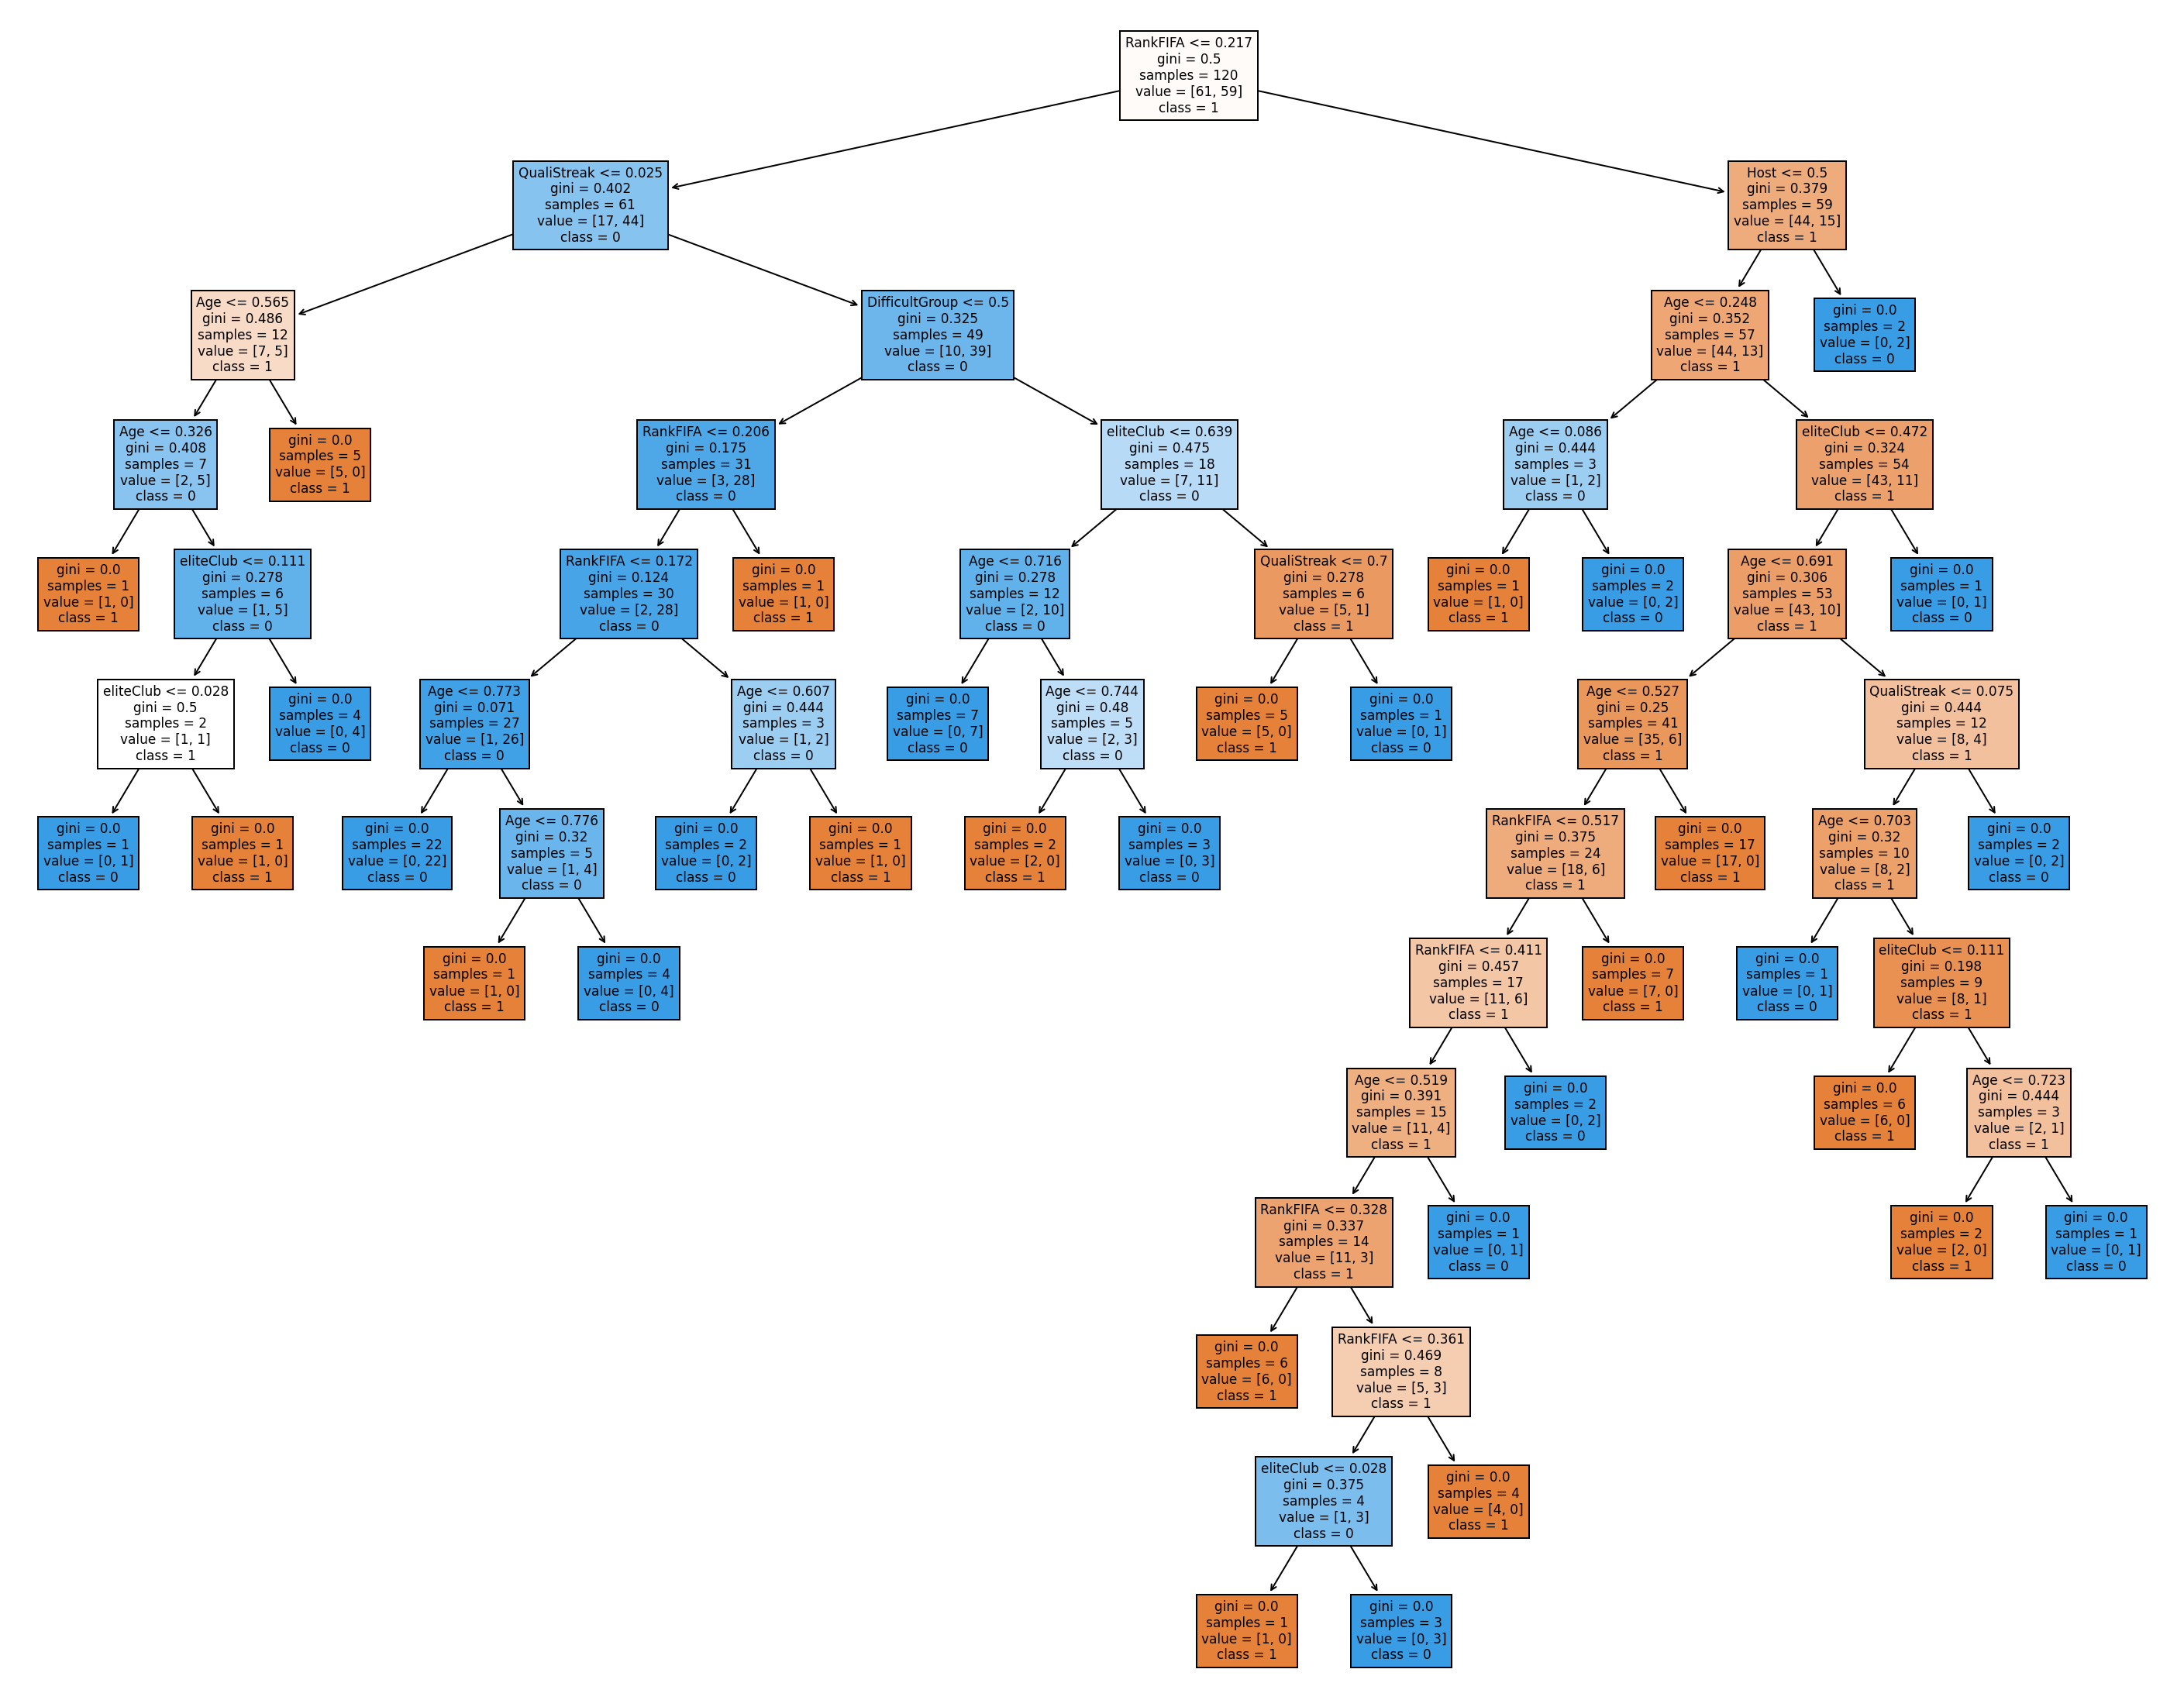

In [6]:
# visualize model
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model, feature_names=df2.columns, class_names=[str(x) for x in label.PastGroup.unique()],filled=True)
plt.show()

**Results for default tree**

Getting an accuracy of 0.6 was somewhat close to a random classifier. That being said, the positive recall, which is the label of interest, had a decent score of 0.62. In an attempt to improve the accuracy of the model, I created a loop to go over various values of maxium depth and compare each depth's performance on training and testing data.


In [7]:
# looping over hyperparameters and compare
test_results=[]
train_results=[]

for num_layer in range(1,20):
    model = tree.DecisionTreeClassifier(max_depth=num_layer, random_state=42)
    model = model.fit(X_train, y_train)

    yp_train=model.predict(X_train)
    yp_test=model.predict(X_test)

    # print(y_pred.shape)
    test_results.append([num_layer,accuracy_score(y_test, yp_test),recall_score(y_test, yp_test,pos_label=0),recall_score(y_test, yp_test,pos_label=1)])
    train_results.append([num_layer,accuracy_score(y_train, yp_train),recall_score(y_train, yp_train,pos_label=0),recall_score(y_train, yp_train,pos_label=1)])

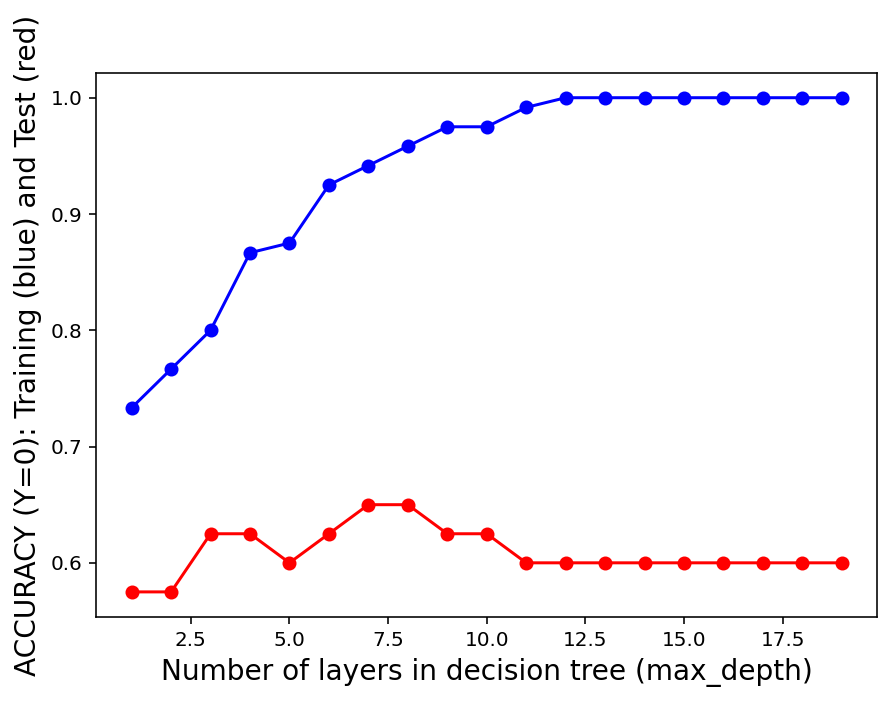

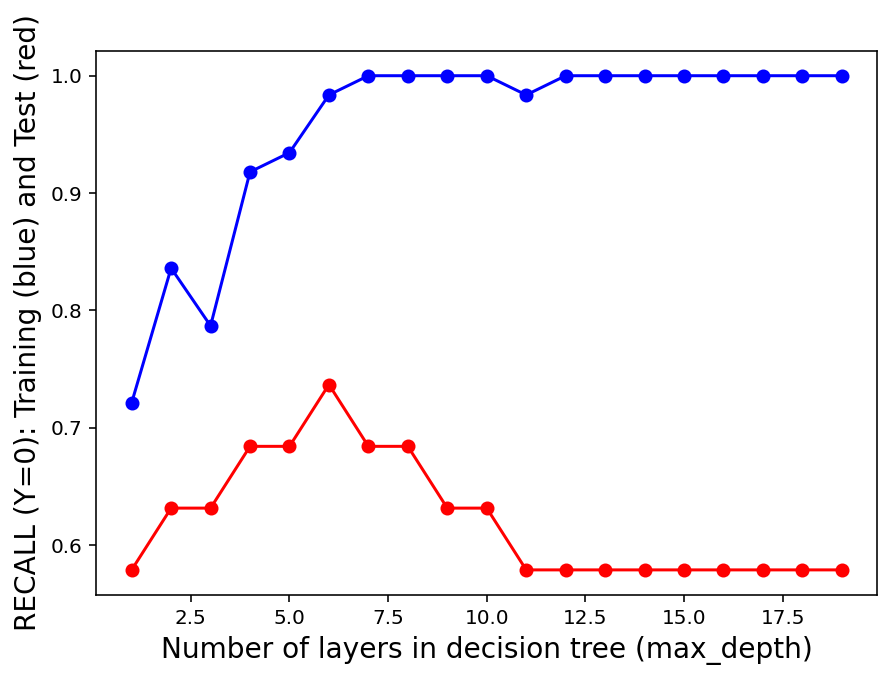

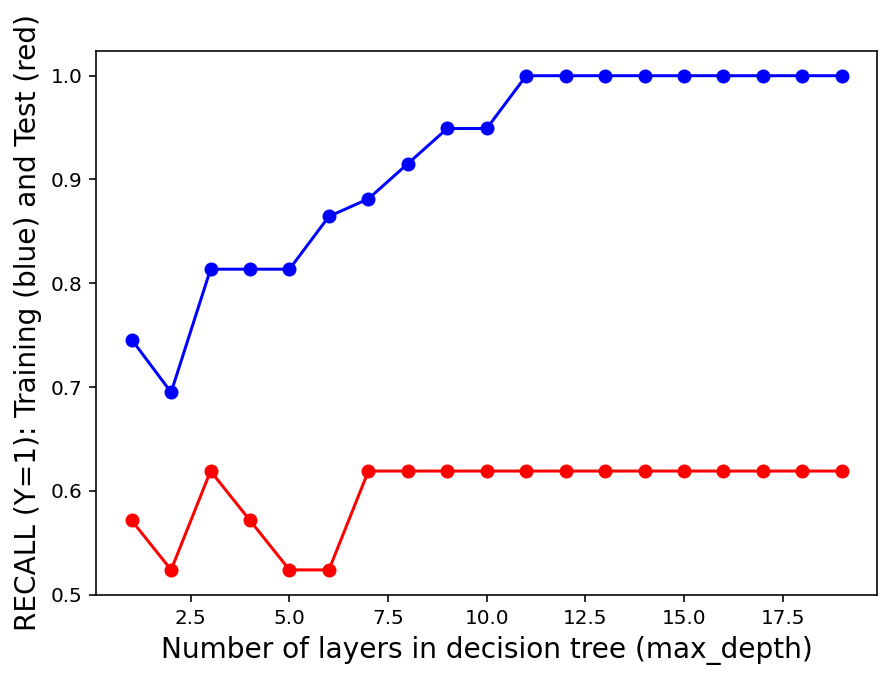

In [8]:
# generate plots to find best hyperparameters
test = pd.DataFrame(test_results, columns=['layers', 'accuracy', 'negativeRecall', 'positiveRecall'])
train = pd.DataFrame(train_results, columns=['layers', 'accuracy', 'negativeRecall', 'positiveRecall'])

plt.figure(figsize=(7,5))
plt.plot(test['layers'], test['accuracy'], 'r-o')
plt.plot(train['layers'], train['accuracy'], 'b-o')
plt.xlabel('Number of layers in decision tree (max_depth)', fontsize=14)
plt.ylabel('ACCURACY (Y=0): Training (blue) and Test (red)', fontsize=14)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(test['layers'], test['negativeRecall'], 'r-o')
plt.plot(train['layers'], train['negativeRecall'], 'b-o')
plt.xlabel('Number of layers in decision tree (max_depth)', fontsize=14)
plt.ylabel('RECALL (Y=0): Training (blue) and Test (red)', fontsize=14)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(test['layers'], test['positiveRecall'], 'r-o')
plt.plot(train['layers'], train['positiveRecall'], 'b-o')
plt.xlabel('Number of layers in decision tree (max_depth)', fontsize=14)
plt.ylabel('RECALL (Y=1): Training (blue) and Test (red)', fontsize=14)
plt.show()

**Optimal model**

After seeing the plots and their respective scores, I selected the max depth with the best metrics and created a decision tree with the optimal parameters.


------TRAINING------
ACCURACY: 0.9583333333333334
NEGATIVE RECALL (Y=0): 1.0
NEGATIVE PRECISION (Y=0): 0.9242424242424242
POSITIVE RECALL (Y=1): 0.9152542372881356
POSITIVE PRECISION (Y=1): 1.0
[[61  0]
 [ 5 54]]


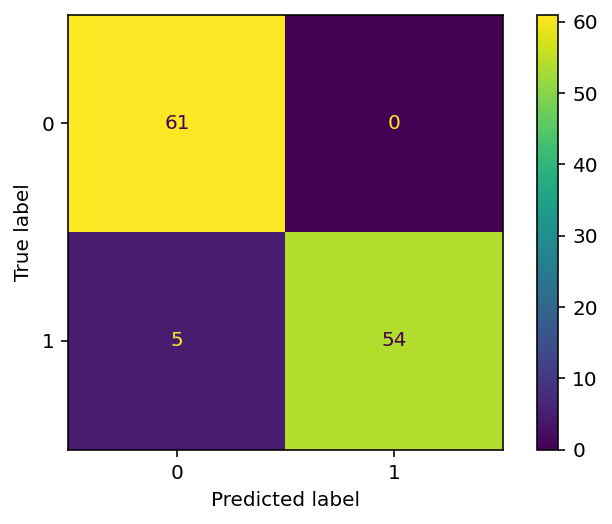

------TEST------
ACCURACY: 0.65
NEGATIVE RECALL (Y=0): 0.6842105263157895
NEGATIVE PRECISION (Y=0): 0.6190476190476191
POSITIVE RECALL (Y=1): 0.6190476190476191
POSITIVE PRECISION (Y=1): 0.6842105263157895
[[13  6]
 [ 8 13]]


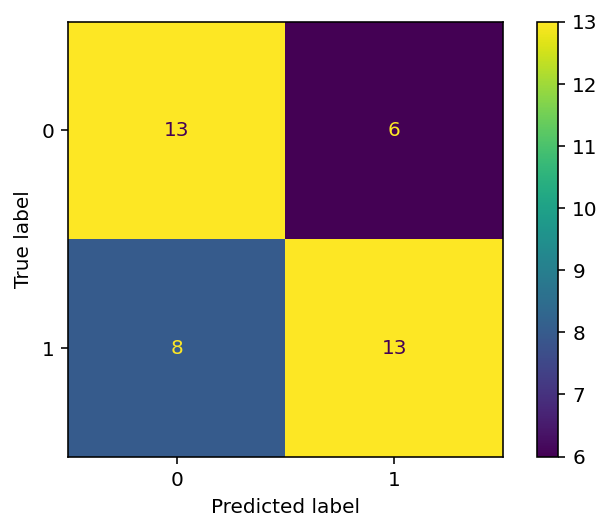

In [9]:
# retrying the model with the best parameters
model = tree.DecisionTreeClassifier(max_depth=8, random_state=42)
model = model.fit(X_train,y_train)
# making predictions with the model on the training and the testing data
yp_train = model.predict(X_train)
yp_test = model.predict(X_test)
# testing model
print("------TRAINING------")
confusion_plot(y_train,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

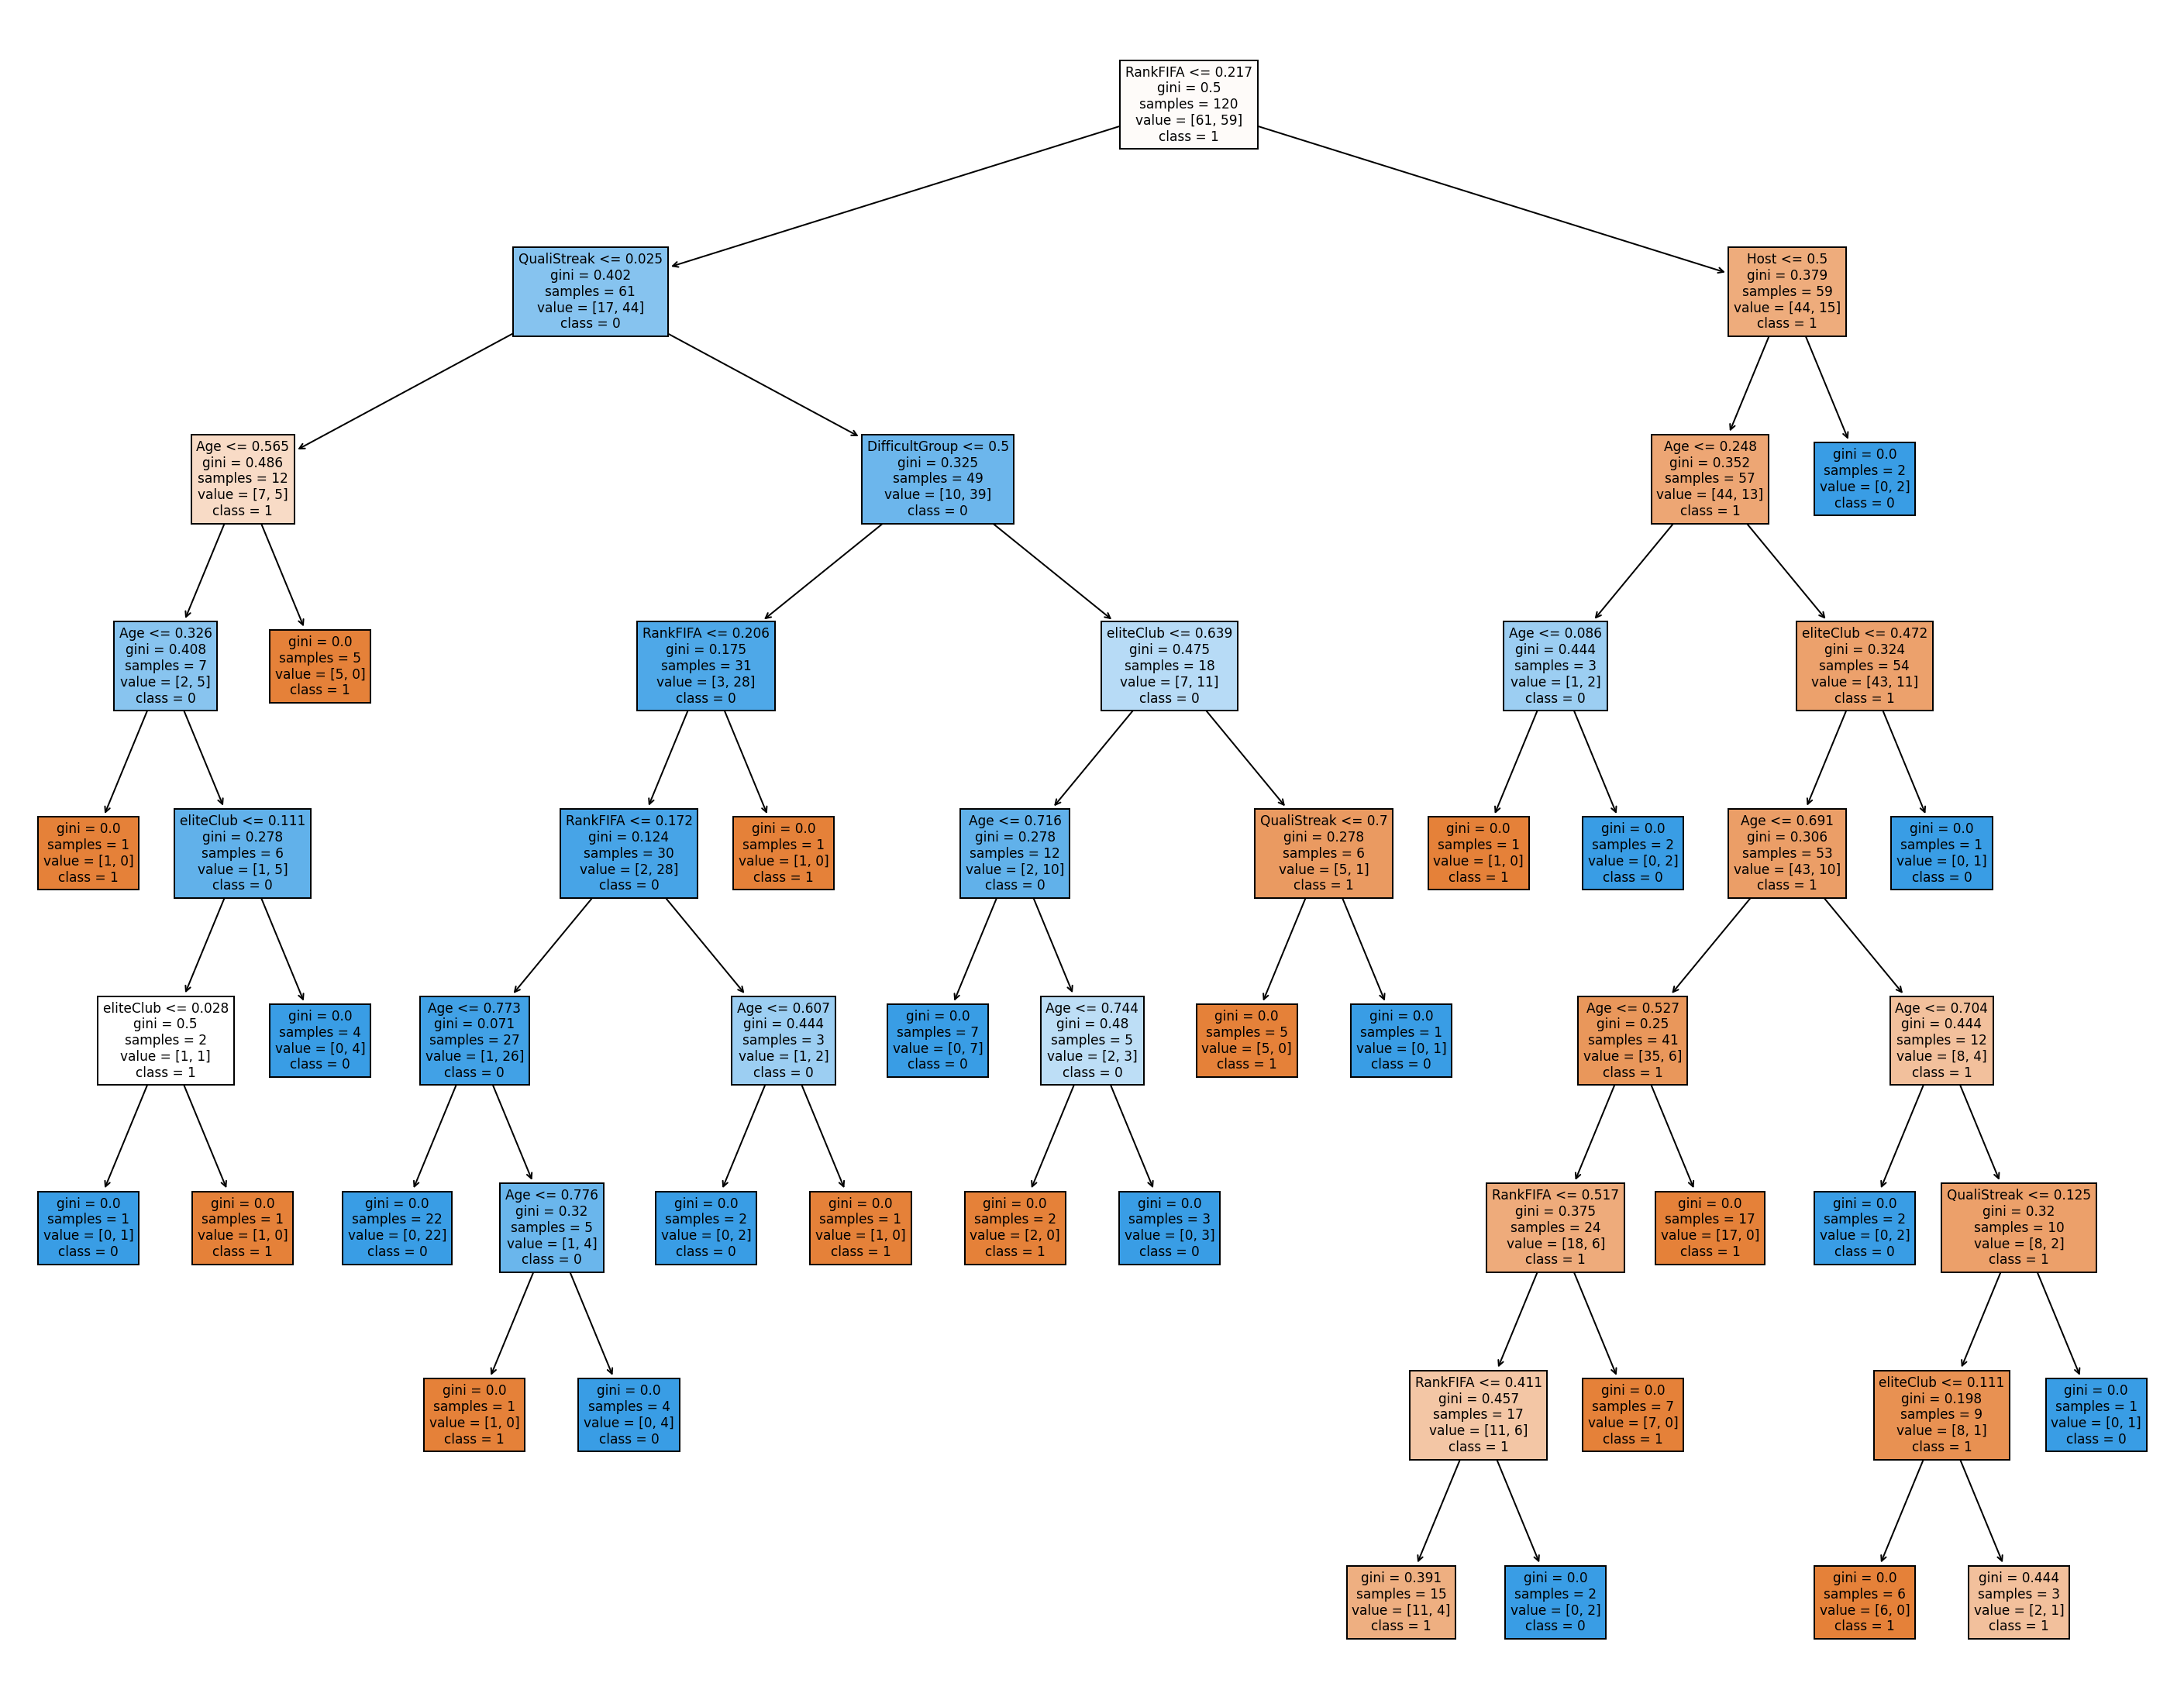

In [10]:
# visualize model
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model, feature_names=df2.columns, class_names=[str(x) for x in label.PastGroup.unique()],filled=True)
plt.show()

**Baseline model for comparison**

In order to compare my predictive model, I created a baseline predictor with a 50-50 chance of generating each label (due to the 50-50 distribution).

-----GENERATING DATA-----
unique entries: dict_keys([1, 0])
count of labels: dict_values([23, 17])
probability of labels: [0.575 0.425]
ACCURACY: 0.45
NEGATIVE RECALL (Y=0): 0.3684210526315789
NEGATIVE PRECISION (Y=0): 0.4117647058823529
POSITIVE RECALL (Y=1): 0.5238095238095238
POSITIVE PRECISION (Y=1): 0.4782608695652174
[[ 7 12]
 [10 11]]


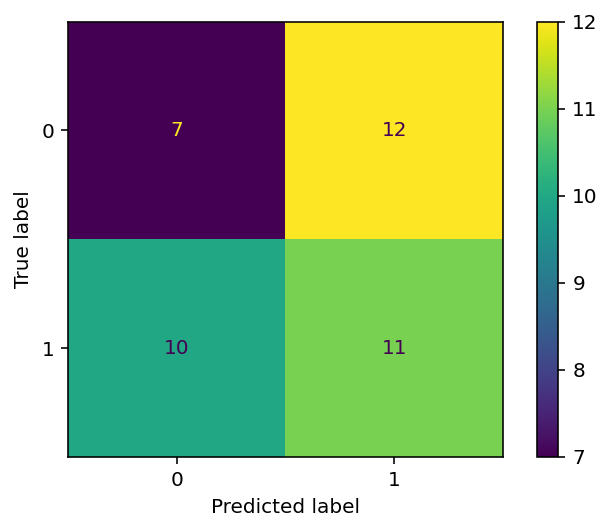

In [11]:
# random classifier
import numpy as np
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def generate_label_data(class_labels, weights,N=10000):
    #e.g. class_labels=[0,1]  weights=[0.2,0.8] (should sum to one)
    random.seed(42)
    y=random.choices(class_labels, weights = weights, k = N)
    print("-----GENERATING DATA-----")
    print("unique entries:",Counter(y).keys())  
    print("count of labels:",Counter(y).values()) # counts the elements' frequency
    print("probability of labels:",np.fromiter(Counter(y).values(), dtype=float)/len(y)) # counts the elements' frequency
    return y

#TEST
y=generate_label_data([0,1],[0.5,0.5],40)

confusion_plot(y_test,y)

**Final Results and conclusion**

The optimal model did indeed yield better results than both the default decision tree and random classifier. The random classifier had an accuracy of 0.45, while the default tree had an accuracy of 0.60 and the optimal tree generated an accuracy of 0.65. From a general perspective, this means that 65% of the guesses made by the model will be correct and the rest will be incorrect.

I think the results aren't great, as I would prefer a model with an accuracy rate above 75%. This model, for now, will have to be qualified as a poor fit. However, we can't only blame the model for the result. It is likely that there isn't enough data to properly train the model. Since World Cups occur only every 4 years, we have a limited amount of data. On top of this, collecting the data has been a struggle. A lot of variables have been qualitative and the overall we only have a few variables available to create the model.

How can we improve the model and the data? The first step would be to improve the data. I need to find more features to help with the model prediction and I have to make sure they are quantitative, rather than qualitative. If after obtaining new data, the model is still underperforming, then I could try a Random Forest and see if that helps with the result. If it doesn't, then we can qualify this model as inappropriate for this specific problem and move on to a different classification method.

Although I won't be able to truly understand the model's performance until the world cup group stage is over, it will be interesting to find if the model is good at predicting dark horses. That is, how many times that a model predicts an unexpected team to perform well does the team perform well? If this specific accuracy is high, then I would be happy with my model's results.